In [ ]:
from util import *
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import pytz
import xgboost as xgb
plt.style.use('ggplot')

df_results = []

For Beijing:
* Air Quality data: https://biendata.com/competition/airquality/bj/2018-04-01-0/2018-04-01-23/2k0d1d8
* Observed Meteorology: https://biendata.com/competition/meteorology/bj/2018-04-01-0/2018-04-01-23/2k0d1d8
* Meteorology Grid Data: https://biendata.com/competition/meteorology/bj_grid/2018-04-01-0/2018-04-01-23/2k0d1d8

For London:
* Air Quality data: https://biendata.com/competition/airquality/ld/2018-05-01-0/2018-05-01-23/2k0d1d8
* Meteorology Grid Data: https://biendata.com/competition/meteorology/ld_grid/2018-05-01-0/2018-05-01-23/2k0d1d8
* 48-future http://kdd.caiyunapp.com/competition/forecast/bj/2018-05-01-0/2k0d1d8
* `curl https://biendata.com/competition/meteorology/ld_grid/ld/2018-03-30-0/2018-04-28-23/2k0d1d8 >> ld_meo_new.csv` 
* `wget https://biendata.com/competition/meteorology/bj_grid/2018-03-30-0/2018-05-01-23/2k0d1d8 -O bj_meo_new.csv`
* `wget https://biendata.com/competition/meteorology/ld_grid/2018-03-30-0/2018-05-01-23/2k0d1d8 -O ld_meo_new.csv`

In [24]:
print("Data loading...")
city = 'ld'
df_aq = pd.read_csv("../input/" + city + "_aq_imputed.csv")
df_aq.utc_time = pd.to_datetime(df_aq.utc_time)
df_meo = get_meo(city)
df_station = pd.read_csv("../input/" + city +"_aq_stations.csv")
df_sample = get_submission_init(df_station, city)
df_ = pd.concat([df_aq, df_sample])

Data loading...


## Feature Engineering

In [25]:
# Join station
df_ = pd.merge(df_, df_station, 'left', left_on='stationId', right_on='Station_ID')

# Join meo
df_.longitude = df_.longitude.round(1)
df_.latitude = df_.latitude.round(1)
df_ = pd.merge(df_, df_meo, 'left', 
              left_on=['utc_time', 'longitude', 'latitude'], 
              right_on=['utc_time', 'longitude', 'latitude']
             )

df_['month'] = df_.utc_time.dt.month
df_['day'] = df_.utc_time.dt.day
df_['hour'] = df_.utc_time.dt.hour
df_['weekday'] = df_.utc_time.dt.weekday
df_['weekofyear'] = df_.utc_time.dt.weekofyear


# FE with aq_stats
df_aq_table = get_aq_stats(df_aq)
df_aq_table = df_aq_table.reset_index()
df_ = pd.merge(df_, df_aq_table, how='left', suffixes=("", "_stats"),
                     left_on =['stationId', 'weekofyear', 'hour'], 
                     right_on=['stationId', 'weekofyear', 'hour'])

# Imputate with meo_stats
df_meo_table = get_meo_stats(df_meo)
df_meo_table = df_meo_table.reset_index()
df_fe = pd.merge(df_, df_meo_table, how='left', suffixes=("", "_stats"),
                     left_on =['latitude', 'longitude', 'weekofyear', 'hour'], 
                     right_on=['latitude', 'longitude', 'weekofyear', 'hour'])

for target in [ 'temperature', 'pressure', 'humidity', 'wind_direction', 'wind_speed/kph']:
    df_fe.loc[df_fe[target].isnull(), target] = df_fe[target + '_stats']

df_fe['wind_direction'] = pd.cut(df_fe['wind_direction'], bins=8, labels=False)

# le_station_type = LabelEncoder()
# le_station_type.fit(df.station_type)
# df.station_type = le_wind_direction.transform(df.station_type)

# le_stationId = LabelEncoder()
# le_stationId.fit(df.stationId)
# df.stationId = le_stationId.transform(df.stationId)
df = pd.get_dummies(df_fe, columns=['month', 'day', 'hour', 'weekday', 'stationId', 'station_type', 'wind_direction'])


In [26]:
X_cols_exclude = [ 'PM2.5', 'PM10', 'O3', 'Station_ID', 'SiteName', 'api_data', 'need_prediction', 'historical_data', 
                  'utc_time', 'pressure_pred', 'temperature_pred', 'wind_direction_pred', 'wind_speed/kph_pred', 
                  'humidity_pred', 'index', 'longitude', 'latitude', 'stationName', 'weekofyear']
X_cols = [col for col in df.columns if col not in X_cols_exclude]

valid_time_start = (pd.datetime.now(pytz.utc)-pd.DateOffset(6)).strftime('%Y-%m-%d 00:00:00')
valid_time_stop = (pd.datetime.now(pytz.utc)-pd.DateOffset(4)).strftime('%Y-%m-%d 00:00:00')

test_time = (pd.datetime.now(pytz.utc)-pd.DateOffset(-1)).strftime('%Y-%m-%d 00:00:00')

if city=='ld':
    df = df.drop(df[df.need_prediction.isnull() & (df['PM2.5'].isnull() | df['PM10'].isnull())].index)
df_train = df[(df.utc_time <= valid_time_start) |
              ((df.utc_time >= valid_time_stop) &(df.utc_time < test_time))
             ]
df_valid = df[(df.utc_time >= valid_time_start) & 
              (df.utc_time < valid_time_stop)]

df_test = df[df.utc_time >= test_time]
if city=='ld':
    df_test = df_test[df_test.need_prediction==1]

X_train = df_train[X_cols]
X_valid = df_valid[X_cols]
X_test = df_test[X_cols]
print(X_train.shape, X_valid.shape, X_test.shape)

(152334, 117) (690, 117) (624, 117)


[0]	train-rmse:14.6503	valid-rmse:8.54997	train-SMAPE:1.20719	valid-SMAPE:1.12108
Multiple eval metrics have been passed: 'valid-SMAPE' will be used for early stopping.

Will train until valid-SMAPE hasn't improved in 20 rounds.
[1]	train-rmse:12.6833	valid-rmse:6.99172	train-SMAPE:1.48827	valid-SMAPE:0.72479
[2]	train-rmse:11.1388	valid-rmse:6.02659	train-SMAPE:0.715448	valid-SMAPE:0.551326
[3]	train-rmse:10.0053	valid-rmse:5.4975	train-SMAPE:0.557722	valid-SMAPE:0.474352
[4]	train-rmse:9.07923	valid-rmse:4.92855	train-SMAPE:0.491841	valid-SMAPE:0.438022
[5]	train-rmse:8.39581	valid-rmse:4.70408	train-SMAPE:0.457721	valid-SMAPE:0.435389
[6]	train-rmse:7.939	valid-rmse:4.65101	train-SMAPE:0.447326	valid-SMAPE:0.607507
[7]	train-rmse:7.54948	valid-rmse:4.60302	train-SMAPE:0.453891	valid-SMAPE:0.512323
[8]	train-rmse:7.21443	valid-rmse:4.63489	train-SMAPE:0.433724	valid-SMAPE:0.4677
[9]	train-rmse:6.99673	valid-rmse:4.63489	train-SMAPE:0.41054	valid-SMAPE:0.461793
[10]	train-rmse:6.79891

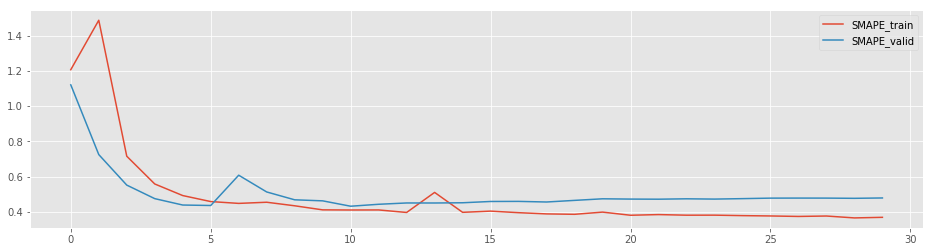

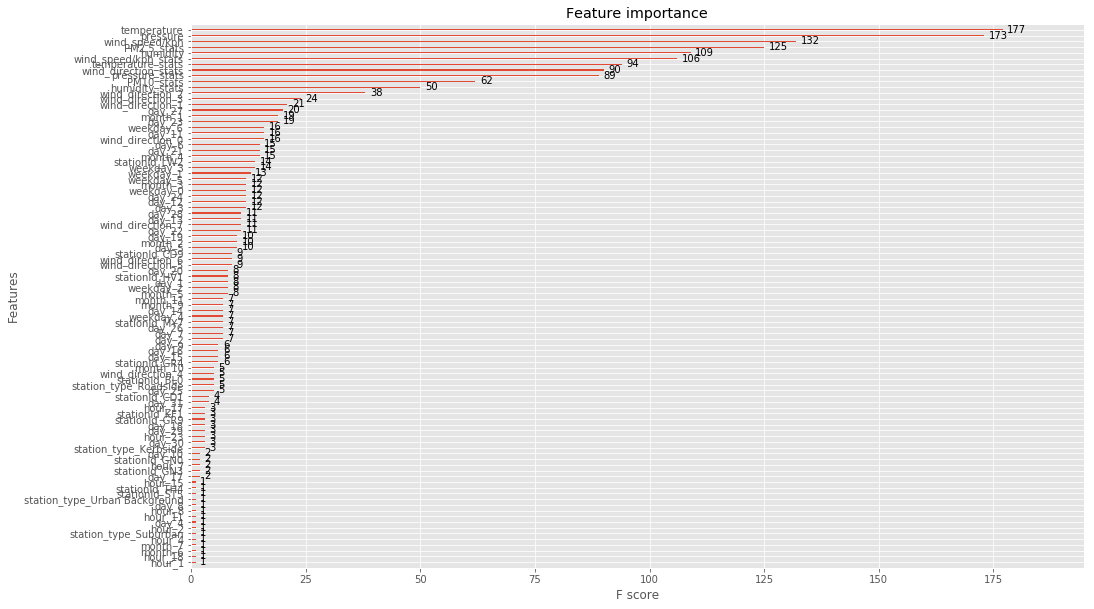

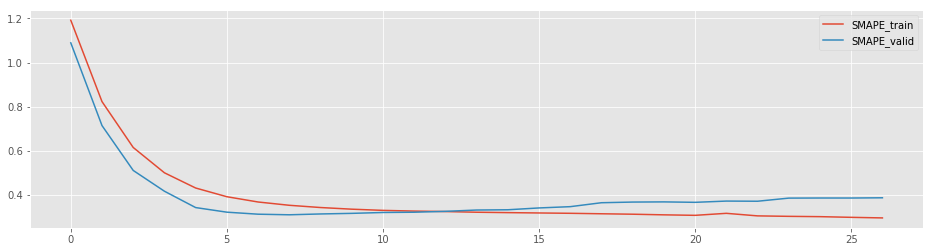

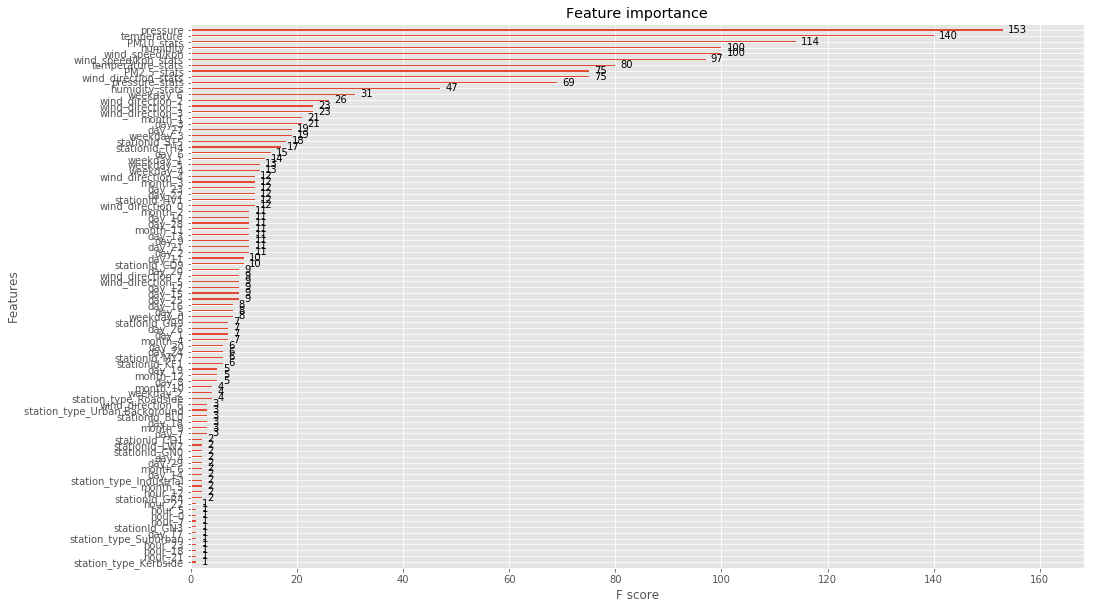

In [27]:
# %%time
y_cols = ['PM2.5', 'PM10', 'O3'] if city=='bj' else ['PM2.5', 'PM10']
bsts = []
gpu_reses = []

for y_col in y_cols:
    y_train = df_train[y_col]
    y_valid = df_valid[y_col]
    y_test = df_test[y_col]

    dtrain = xgb.DMatrix(X_train, y_train)
    dvalid = xgb.DMatrix(X_valid, y_valid, nthread=-1)
    dtest = xgb.DMatrix(X_test, nthread=-1)

    param = {
        'max_depth': 6,
        'learning_rate': 0.2,
        'n_estimators': 3000,
        'colsample_bytree': 0.8,
#         'subsample': 1,
        'min_child_weight': 2, 
        'reg_alpha': 0.01, 
        'objective':'gpu:reg:linear',
        'tree_method': 'gpu_hist',
        'random_state': 0,
    }

    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
    gpu_res = {}
    bst = xgb.train(param, dtrain, num_boost_round=300, evals=watchlist , feval=SMAPE, 
                    early_stopping_rounds=20, evals_result=gpu_res)

    bsts.append(bst)
    gpu_reses.append(gpu_res)

    df_metric = pd.concat([pd.DataFrame(gpu_res['train']['SMAPE']), pd.DataFrame(gpu_res['valid']['SMAPE'])], axis=1)
    df_metric.columns = ['SMAPE_train', 'SMAPE_valid']
    df_metric.plot(figsize=(16, 4))
    fig, ax = plt.subplots(figsize=(16, 10))
    xgb.plot_importance(bst, ax=ax)

In [28]:
for i, y_col in enumerate(y_cols):
    y_pred = bsts[i].predict(dtest, ntree_limit=bst.best_iteration)
    df_test[y_col] = y_pred

df_test = df_test[['Station_ID', 'utc_time'] + y_cols]
df_result = df_test.groupby(['Station_ID', 'utc_time']).mean().reset_index()

start_time = (pd.datetime.now(pytz.utc)-pd.DateOffset(-1)).strftime('%Y-%m-%d 00:00:00')
end_time = (pd.datetime.now(pytz.utc)-pd.DateOffset(-2)).strftime('%Y-%m-%d 23:00:00')
utc_time = pd.date_range(start=start_time, end=end_time, freq="1H")
time_to_idx = {time:str(i) for i, time in enumerate(utc_time)}
df_result['test_id'] = df_result.Station_ID + "#" + df_result.utc_time.apply(lambda time: time_to_idx[time])

if city=='ld':
    df_result['O3'] = 0
df_result = df_result[['test_id', 'PM2.5', 'PM10', 'O3']]
df_result.to_csv("../submission/"+ mmdd + "_" + city + ".csv", index=False)
print(city, start_time, end_time)

ld 2018-05-04 00:00:00 2018-05-05 23:00:00


## Submission

In [31]:
mmdd = pd.datetime.now(pytz.utc).strftime('%m%d')
filename = "iar_"+ mmdd + "_xgb.csv"
# kdd_2018_submit(filename, 'xgboost basic')

'iar_0503_xgb.csv'

## LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# X_cols_exclude = [ 'PM2.5', 'PM10', 'O3', 'Station_ID', 'SiteName', 'api_data', 'need_prediction', 'historical_data', 
#                   'utc_time', 'pressure_pred', 'temperature_pred', 'wind_direction_pred', 'wind_speed/kph_pred', 
#                   'humidity_pred', 'index', 'longitude', 'latitude', 'stationName', 'weekofyear']
# X_cols = [col for col in df.columns if col not in X_cols_exclude]

# valid_time = (pd.datetime.now(pytz.utc)-pd.DateOffset(2)).strftime('%Y-%m-%d 00:00:00')
# test_time = pd.datetime.now(pytz.utc).strftime('%Y-%m-%d 00:00:00')

# if city=='ld':
#     df = df.drop(df[df.need_prediction.isnull() & (df['PM2.5'].isnull() | df['PM10'].isnull())].index)

# df_X = df[X_cols]
# # df_train = df[df.utc_time < valid_time]
# # df_valid = df[(df.utc_time >= valid_time) & (df.utc_time < test_time)]
# # df_test = df[df.utc_time >= test_time]
# # if city=='ld':
# #     df_test = df_test[df_test.need_prediction==1]

# X_train = df_X[df.utc_time < valid_time]
# X_valid = df_X[(df.utc_time >= valid_time) & (df.utc_time < test_time)]
# X_test = df_X[df.utc_time >= test_time]



In [ ]:
# # convert series to supervised learning
# def series_to_supervised(data, n_in=1, n_out=, dropnan=True):
#     n_vars = 1 if type(data) is list else data.shape[1]
#     df = pd.DataFrame(data)
#     cols, names = list(), list()
#     # input sequence (t-n, ... t-1)
#     for i in range(n_in, 0, -1):
#         cols.append(df.shift(i))
#         names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

#     # forecast sequence (t, t+1, ... t+n)
#     for i in range(0, n_out):
#         cols.append(df.shift(-i))
#         if i == 0:
#             names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
#         else:
#             names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
#     # put it all together
#     agg = pd.concat(cols, axis=1)
#     agg.columns = names
#     # drop rows with NaN values
#     if dropnan:
#         agg.dropna(inplace=True)
#     return agg

# dataset = pd.read_csv('../../playground/Forecasting-on-Air-pollution-with-RNN-LSTM/pollution.csv', header=0, index_col=0)
# values = dataset.values
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4]) # 风向那一行
# values = values.astype('float32')
# scaler = StandardScaler()
# scaled = scaler.fit_transform(values)
# reframed = series_to_supervised(scaled, 48, 48)

# for col, t in df.dtypes.iteritems():
#     if np.issubdtype(t, np.number):
#         scaler = StandardScaler()
#         df_X[col] = scaler.fit_transform(df_X[col])

## Prophet

In [ ]:
# from fbprophet import Prophet
# target = 'PM2.5'
# df_prophet = df[['utc_time', target]]
# df_prophet.columns = ['ds', 'y']
# df_prophet['y'] = np.log(df_prophet['y'])

In [ ]:
valid_time_start

In [ ]:
valid_time_stop = (pd.datetime.now(pytz.utc)-pd.DateOffset(4)).strftime('%Y-%m-%d 00:00:00')
valid_time_stop